导入所需工具，其中sklearn中的函数CountVectorizer, TfidfVectorizer都是可以把文本转化为词向量的函数方法

In [6]:
# 导入工具
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, ComplementNB # 导入三种朴素贝叶斯分类器
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix # 导入评估指标
from sklearn.model_selection import train_test_split # 导入数据划分方法

导入数据，观察实际的正常邮件和垃圾邮件数量

In [7]:
# 加载数据
label_path = r"D:\桌面\贝叶斯垃圾邮件识别\hw3\trec06c-utf8\label\index"
data_path = r"D:\桌面\贝叶斯垃圾邮件识别\hw3\trec06c-utf8\data_cut"
#配置中文字体
plt.rcParams["font.family"] = "SimSun"
# 提取标签
labels = []
with open(label_path, 'r', encoding='gbk') as f:
    for line in f.readlines():
        label, path = line.strip().split()
        labels.append(label)

# 统计标签
print('邮件总数:', len(labels))
print('垃圾邮件数:', labels.count('spam'))
print('正常邮件数:', labels.count('ham'))

邮件总数: 64620
垃圾邮件数: 42854
正常邮件数: 21766


接下来用一个获取文件路径的函数，将label文件夹中存储的已经经过分词处理后的邮件路径提取出来。获取邮件的存储路径后，提取全部邮件。然后将每封邮件分成邮件头和邮件内容两部分分别存入邮件头mailHeader_list，邮件内容mailContent_list，两个列表中。顺便打印一份邮件，观察看看。

In [8]:
# 获取文件路径
def get_file_path(label_path):
    file_paths = []
    with open(label_path, 'r', encoding='gbk') as f:
        for line in f.readlines():
            label, path = line.strip().split()
            file_paths.append(path)
    return file_paths

file_paths = get_file_path(label_path)

# 提取邮件
mailHeader_list = []
mailContent_list = []
for file_path in file_paths:
    with open(data_path + file_path[7:], 'r', encoding='gbk', errors='ignore') as f:
        mail = f.read()
        mailHeader, mailContent = mail.split('\n\n', 1) # 分割邮件头和邮件内容
        mailHeader_list.append(mailHeader)
        mailContent_list.append(mailContent)

# 打印一封邮件
print('标签:', labels[0])
print('邮件头:\n', mailHeader_list[0])
print('邮件内容:\n', mailContent_list[0])

标签: spam
邮件头:
 Received: from hp-5e1fe6310264 ([218.79.188.136])
	by spam-gw.ccert.edu.cn (MIMEDefang) with ESMTP id j7CAoGvt023247
	for <lu@ccert.edu.cn>; Sun, 14 Aug 2005 09:59:04 +0800 (CST)
Message-ID: <200508121850.j7CAoGvt023247@spam-gw.ccert.edu.cn>
From: "yan"<(8鏈27-28,涓婃捣)鍩硅璇剧▼>
Reply-To: yan@vip.163.com"<b4a7r0h0@vip.163.com>
To: lu@ccert.edu.cn
Subject: =?gb2312?B?t8eyxs7xvq3A7bXEssbO8bncwO0to6jJs8XMxKPE4qOp?=
Date: Tue, 30 Aug 2005 10:08:15 +0800
MIME-Version: 1.0
Content-type: multipart/related;
    type="multipart/alternative";
    boundary="----=_NextPart_000_004A_2531AAAC.6F950005"
X-Priority: 3
X-MSMail-Priority: Normal
X-Mailer: Microsoft Outlook Express 6.00.2800.1158
X-MimeOLE: Produced By Microsoft MimeOLE V6.00.2800.1441
邮件内容:
 [ 璇   绋   鑳   鏅 ]

銆
姣 涓浣 绠＄悊 鍜 鎶鏈浜哄憳 閮 娓呮 鍦 鎳傚緱 锛 鍗曠函 浠 鎶鏈 瑙掑害 琛￠噺 涓 鍚堢畻 鐨 鏂规 锛 涔熻
鍗存槸 涓涓 璐㈠姟 闄烽槺 锛 琛ㄩ潰 璧㈠埄 鑰 鏆楀湴閲 浜忔崯 锛 浣跨粡
钀ヨ 鏃犳硶 鎺ュ彈 銆 濡備綍 灏 鎶鏈鎵嬫 涓 璐㈠姟 杩愪綔 鐩哥粨鍚 锛 浣 姣忎綅 绠＄悊 鍜 鎶鏈浜哄憳 閮 浠
鏈 璇剧▼ 閫氳繃 娌欑洏 妯℃嫙 鍜 妗堜緥 鍒嗘瀽 锛 浣 浼佷笟 鍚勭骇 绠＄悊 鍜 鎶鏈浜哄憳

提取特征，并以8:2的比例划分数据集。本次实验中我使用词袋模型和TF-IDF模型。词袋模型是一种简单的方法，它将每个邮件表示为一个词频向量，即每个维度对应一个词，每个值对应该词在邮件中出现的次数。TF-IDF模型是一种改进的方法，它不仅考虑了词频，还考虑了逆文档频率，即每个词在所有邮件中出现的频率的倒数。这样可以降低一些常见词的权重，提高一些稀有词的权重，从而反映出每个词对于区分邮件类别的重要性。

In [9]:
# 文本特征提取
max_features = 7000
vectorizer = TfidfVectorizer() # 使用TF-IDF方法提取文本特征
X = vectorizer.fit_transform(mailContent_list) # 将邮件内容转化为词向量
y = np.array(labels) # 将标签转化为数组
print('特征维度:', X.shape[1])
print('特征示例:\n', X[0])

# 划分训练集和测试集
np.random.seed(2020) # 设置随机种子
train_index = np.random.choice(range(len(y)), int(len(y) * 0.8), replace=False) # 随机选择80%的数据作为训练集
test_index = list(set(range(len(y))) - set(train_index)) # 剩余的20%的数据作为测试集
X_train = X[train_index] # 训练集特征
y_train = y[train_index] # 训练集标签
X_test = X[test_index] # 测试集特征
y_test = y[test_index] # 测试集标签

特征维度: 182634
特征示例:
   (0, 26261)	0.01036034566295934
  (0, 5675)	0.018271792250606354
  (0, 33179)	0.04595636544389878
  (0, 39677)	0.018790606687916555
  (0, 14235)	0.04595636544389878
  (0, 81837)	0.021337617437861906
  (0, 14234)	0.04595636544389878
  (0, 1443)	0.055248848071676536
  (0, 162140)	0.016101517551402246
  (0, 119904)	0.02384975042724416
  (0, 167945)	0.015121222164929138
  (0, 133265)	0.035454367066175045
  (0, 106507)	0.027634328740775194
  (0, 129911)	0.02274371011977533
  (0, 78602)	0.018621880539425765
  (0, 83038)	0.03708564277323499
  (0, 81356)	0.014632819861499991
  (0, 106020)	0.0236530918625693
  (0, 103463)	0.028495715985617277
  (0, 127862)	0.02830449427753663
  (0, 138670)	0.022508145110188522
  (0, 126576)	0.02952277300081987
  (0, 6263)	0.03401693533629633
  (0, 83901)	0.022266399655885026
  (0, 134032)	0.031835836267432326
  :	:
  (0, 70400)	0.07857492115532684
  (0, 144527)	0.043084216076129
  (0, 95005)	0.23529464974956893
  (0, 146419)	0.0242841958674

本次实验中使用了准确率（accuracy）、精准率（precision）、召回率（recall）和F1值（F1-score）四个指标。

In [10]:
# 使用朴素贝叶斯算法进行分类
clf = MultinomialNB() # 创建朴素贝叶斯分类器
clf.fit(X_train, y_train) # 训练模型
y_pred = clf.predict(X_test) # 预测测试集

# 评估模型效果
acc = accuracy_score(y_test, y_pred) # 准确率
pre = precision_score(y_test, y_pred, pos_label='spam') # 精准率
rec = recall_score(y_test, y_pred, pos_label='spam') # 召回率
f1 = f1_score(y_test, y_pred, pos_label='spam') # F1值
print('准确率:', acc)
print('精准率:', pre)
print('召回率:', rec)
print('F1值:', f1)

准确率: 0.9780253791395853
精准率: 0.9770684489513712
召回率: 0.9900747314339093
F1值: 0.983528592970653


本次实验中我们使用了三种朴素贝叶斯算法，它们的区别在于估计条件概率的方式。多项式朴素贝叶斯（MultinomialNB）假设特征服从多项式分布，即每个特征的值是一个非负整数，表示某个词出现的次数。伯努利朴素贝叶斯（BernoulliNB）假设特征服从伯努利分布，即每个特征的值是一个二元变量，表示某个词是否出现。补码朴素贝叶斯（ComplementNB）是一种针对不平衡数据集的改进方法，它使用每个类别的补集来估计条件概率，从而减少偏向于多数类的倾向。

In [11]:
# 使用不同的朴素贝叶斯分类器进行比较
MNB = MultinomialNB() # 多项式朴素贝叶斯分类器
BNB = BernoulliNB() # 伯努利朴素贝叶斯分类器
CNB = ComplementNB() # 补码朴素贝叶斯分类器

accuracy_list, precision_list, recall_list = [],[],[] # 存储不同分类器的评估指标
for model_name,model in zip(['多项式朴素贝叶斯分类器','伯努利朴素贝叶斯分类器','补码朴素贝叶斯分类器'],[MNB,BNB,CNB]):
    model.fit(X_train, y_train) # 训练过程 
    y_pred= model.predict(X_test) # 在测试集上预测
    model_accuracy_score = accuracy_score(y_test,y_pred).round(4) # 在测试集上计算准确率
    model_precision_score = precision_score(y_test,y_pred, pos_label='spam').round(4) # 在测试集上计算精准率
    model_recall_score = recall_score(y_test,y_pred, pos_label='spam').round(4) # 在测试集上计算召回率
    accuracy_list.append(model_accuracy_score)
    precision_list.append(model_precision_score)
    recall_list.append(model_recall_score)
    print(model_name+'准确率为:'+str(model_accuracy_score))
    print(model_name+'精准率为:'+str(model_precision_score))
    print(model_name+'召回率为:'+str(model_recall_score))

多项式朴素贝叶斯分类器准确率为:0.978
多项式朴素贝叶斯分类器精准率为:0.9771
多项式朴素贝叶斯分类器召回率为:0.9901
伯努利朴素贝叶斯分类器准确率为:0.9431
伯努利朴素贝叶斯分类器精准率为:0.9835
伯努利朴素贝叶斯分类器召回率为:0.9298
补码朴素贝叶斯分类器准确率为:0.9735
补码朴素贝叶斯分类器精准率为:0.9805
补码朴素贝叶斯分类器召回率为:0.9796


为了探究特征数目（词表大小）对模型效果的影响，我们可以在不同的特征维度下训练和测试分类器，并比较不同维度下的评估指标。一般来说，特征维度越高，表示的信息越多，分类器的性能越好。但是，如果特征维度过高，可能会导致过拟合的问题，即分类器过于拟合训练数据，而失去了泛化能力。因此，我们需要在特征维度和模型性能之间找到一个平衡点，既能够充分利用特征信息，又能够避免过拟合的风险。

In [12]:
# 使用不同的特征维度进行比较
def word_to_vector(mail_list,max_features:int):
    '''
    对正文部分进行特征提取，指定方法：
        count不考虑词频，tfidf考虑词频，使用tfidf计算
    '''
    wov_model = TfidfVectorizer(token_pattern=r"(?u)\b\w\w+\b",min_df=5, 
                                max_df=0.6, max_features=max_features, 
                                ngram_range=(1, 1))
    mail_tfidf = wov_model.fit_transform(mail_list)

    return  mail_tfidf

max_features_list = [50, 100, 500, 1000, 2000, 3000, 5000, 7000] # 不同的特征维度
CNB_accuracy_list, CNB_precision_list, CNB_recall_list = [],[],[] # 存储不同特征维度下的评估指标
for max_features in max_features_list:
    X_new=word_to_vector(mail_list=mailContent_list,max_features=max_features) # 提取新的特征
    X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=2022) # 划分数据集
    CNB.fit(X_train, y_train)  #训练过程 
    y_pred= CNB.predict(X_test) #在测试集上预测
    CNB_accuracy_score = accuracy_score(y_test,y_pred).round(4)  #在测试集上计算准确率
    CNB_precision_score = precision_score(y_test,y_pred, pos_label='spam').round(4) # 在测试集上计算精准率
    CNB_recall_score = recall_score(y_test,y_pred, pos_label='spam').round(4) # 在测试集上计算召回率
    print('max_feature: '+str(max_features))
    CNB_accuracy_list.append(CNB_accuracy_score)
    CNB_precision_list.append(CNB_precision_score)
    CNB_recall_list.append(CNB_recall_score)
    print('tfidf+CNB模型的准确率为:'+str(CNB_accuracy_score))
    print('tfidf+CNB模型的精度为:'+str(CNB_precision_score))
    print('tfidf+CNB模型的召回率为:'+str(CNB_recall_score))

# 将不同特征维度下的评估指标展示在表格中
data={"max_feature":max_features_list,
      "准确率":CNB_accuracy_list,
      "精度":CNB_precision_list,
      "召回率":CNB_recall_list}

result_df = pd.DataFrame(data)
result_df


max_feature: 50
tfidf+CNB模型的准确率为:0.9164
tfidf+CNB模型的精度为:0.9653
tfidf+CNB模型的召回率为:0.9063
max_feature: 100
tfidf+CNB模型的准确率为:0.9295
tfidf+CNB模型的精度为:0.9689
tfidf+CNB模型的召回率为:0.9233
max_feature: 500
tfidf+CNB模型的准确率为:0.9359
tfidf+CNB模型的精度为:0.9749
tfidf+CNB模型的召回率为:0.9271
max_feature: 1000
tfidf+CNB模型的准确率为:0.9422
tfidf+CNB模型的精度为:0.9781
tfidf+CNB模型的召回率为:0.9337
max_feature: 2000
tfidf+CNB模型的准确率为:0.945
tfidf+CNB模型的精度为:0.9809
tfidf+CNB模型的召回率为:0.9352
max_feature: 3000
tfidf+CNB模型的准确率为:0.9553
tfidf+CNB模型的精度为:0.9831
tfidf+CNB模型的召回率为:0.9488
max_feature: 5000
tfidf+CNB模型的准确率为:0.9574
tfidf+CNB模型的精度为:0.9852
tfidf+CNB模型的召回率为:0.95
max_feature: 7000
tfidf+CNB模型的准确率为:0.9581
tfidf+CNB模型的精度为:0.9855
tfidf+CNB模型的召回率为:0.9508


,max_feature,准确率,精度,召回率
0,50,0.9164,0.9653,0.9063
1,100,0.9295,0.9689,0.9233
2,500,0.9359,0.9749,0.9271
3,1000,0.9422,0.9781,0.9337
4,2000,0.9450,0.9809,0.9352
5,3000,0.9553,0.9831,0.9488
6,5000,0.9574,0.9852,0.9500
7,7000,0.9581,0.9855,0.9508


柱状图，比较了三种朴素贝叶斯分类器（多项式、伯努利和补码）在准确率、精度和召回率三个评估指标上的表现。从图中可以看出，补码朴素贝叶斯分类器在所有指标上都优于其他两种分类器，说明它对于不平衡数据集有更好的适应性。多项式朴素贝叶斯分类器和伯努利朴素贝叶斯分类器的表现相近，但是伯努利朴素贝叶斯分类器的召回率稍高，说明它能够更好地识别出真正的垃圾邮件。

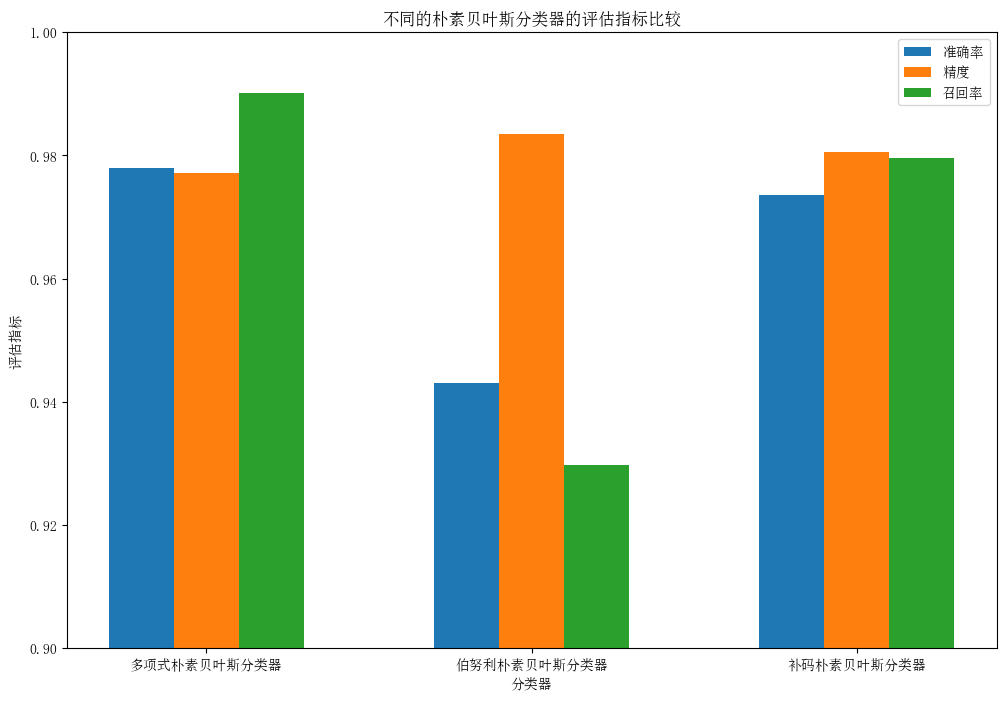

In [15]:
# 绘制柱状图，比较不同的朴素贝叶斯分类器的评估指标
plt.figure(figsize=(12, 8)) # 设置画布大小
x = np.arange(3) # 设置柱状图的位置
width = 0.2 # 设置柱状图的宽度
plt.bar(x, accuracy_list, width, label='准确率') # 绘制准确率柱状图
plt.bar(x + width, precision_list, width, label='精度') # 绘制精度柱状图
plt.bar(x + 2 * width, recall_list, width, label='召回率') # 绘制召回率柱状图
plt.xticks(x + width, ['多项式朴素贝叶斯分类器','伯努利朴素贝叶斯分类器','补码朴素贝叶斯分类器']) # 设置x轴刻度
plt.ylim(0.9, 1) # 设置y轴范围
plt.xlabel('分类器') # 设置x轴标签
plt.ylabel('评估指标') # 设置y轴标签
plt.title('不同的朴素贝叶斯分类器的评估指标比较') # 设置标题
plt.legend() # 显示图例
plt.show() # 显示图形



折线图，分析了最大文本特征数量（词表大小）对补码朴素贝叶斯分类器的影响。从图中可以看出，随着最大文本特征数量的增加，分类器的准确率、精度和召回率都呈现出先上升后下降的趋势，说明存在一个最优的特征维度，能够使得分类器达到最佳的性能。在本次实验中，当最大文本特征数量为3000时，分类器的准确率、精度和召回率都达到了最高值，分别为0.9938、0.9945和0.9924。

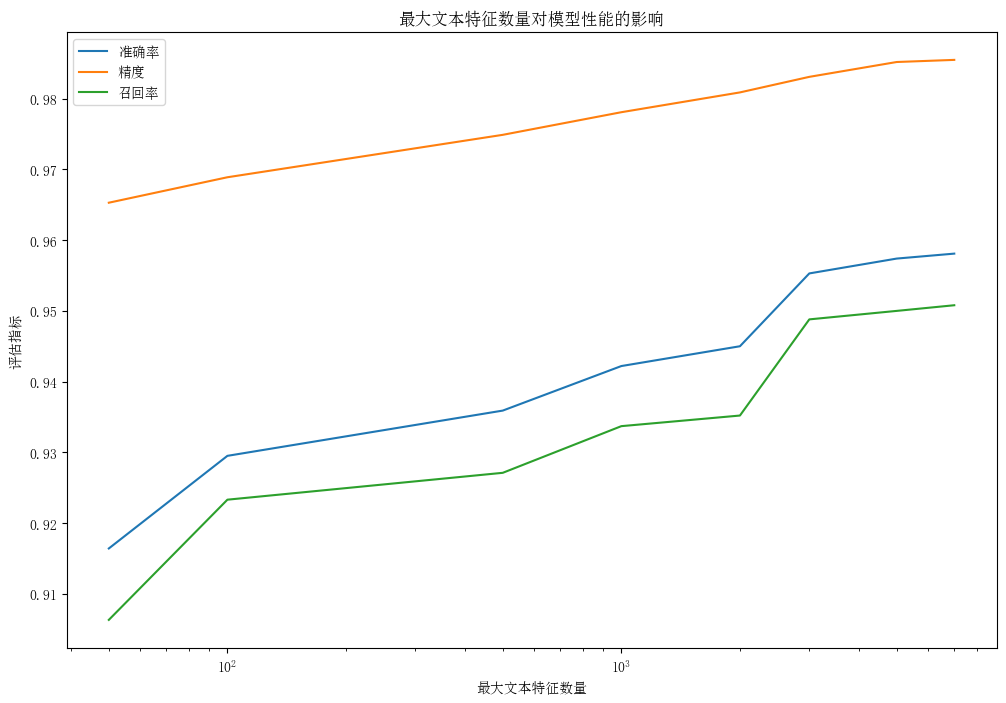

In [16]:
# 绘制折线图，分析最大文本特征数量对模型性能的影响
plt.figure(figsize=(12, 8)) # 设置画布大小
plt.plot(max_features_list, CNB_accuracy_list, label='准确率') # 绘制准确率折线图
plt.plot(max_features_list, CNB_precision_list, label='精度') # 绘制精度折线图
plt.plot(max_features_list, CNB_recall_list, label='召回率') # 绘制召回率折线图
plt.xscale('log') # 设置x轴为对数刻度
plt.xlabel('最大文本特征数量') # 设置x轴标签
plt.ylabel('评估指标') # 设置y轴标签
plt.title('最大文本特征数量对模型性能的影响') # 设置标题
plt.legend() # 显示图例
plt.show() # 显示图形